# M05. Predict Pulls
- This predicts when starting pitchers are removed from a game
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 11/1/2023
    - Updated: 4/21/2024

In [1]:
# Note: we now have earned and unearned runs, for whatever that's worth here.
# rbi_sum isn't quite the same thing as earned runs, but it's maybe closer. Finding actual earned runs is probably possible in the api

### Imports

In [2]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer

import joblib
import matplotlib.pyplot as plt

In [4]:
%run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

### Dataset

In [5]:
complete_dataset = create_pull_inputs(park_factors, team_map, 2015, 2023)

inning    int64
outs      int64
rbi       int64
dtype: object


### Steamer

In [6]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

### Merge

In [7]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [8]:
# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_pitchers_df2[['mlbamid', 'date'] + pitcher_stats_fg2] , left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='left', suffixes=("", "_fg"))
complete_merged_df.drop_duplicates(subset=['date', 'gamePk', 'atBatIndex'], keep='last', inplace=True)

In [9]:
# Remove those with nonzero IP_start and a decent sample
complete_merged_df = complete_merged_df.query('IP_start > 3 and IP_start < 8 and IP > 30')

In [10]:
complete_merged_df.query('year_2022 == 1 or year_2023 == 1')['IP_start'].mean()

5.658869096288981

# Train Models

### Dataset

In [11]:
# # Full dataset
# X = complete_merged_df[pull_inputs]
# y = complete_merged_df['pulled']

# # Split into training and testing groups
# X_train = complete_merged_df.groupby(complete_merged_df['year']).apply(lambda x: x.head(int(len(x)*2/3)))
# X_test = complete_merged_df.groupby(complete_merged_df['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

In [12]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
complete_merged_df['split'] = np.random.choice([0, 0, 1], size=len(complete_merged_df))

# Split the DataFrame into training and testing sets based on the 'split' column
X_train = complete_merged_df[complete_merged_df['split'] == 0].drop('split', axis=1)
X_test = complete_merged_df[complete_merged_df['split'] == 1].drop('split', axis=1)

### Pulls

In [54]:
%%time
pulls_filename = f"model_pulls_voting_{todaysdate}.sav"
print(pulls_filename)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', random_state=110, early_stopping=True, max_iter=100),  
    ]

# Create the ensemble classifier using VotingClassifier
model_pulls = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train[pull_inputs], X_train[['pulled']].values.ravel())

# Save model
pickle.dump(model_pulls, open(os.path.join(model_path, pulls_filename), 'wb'))

model_pulls_voting_20240326.sav
CPU times: total: 31.2 ms
Wall time: 1min 17s


In [55]:
# Make predictions
proba = model_pulls.predict_proba(X_test[pull_inputs])
X_test['is_kept_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_pulled_pred'] = proba[:, 1]  # Assign the second column of probabilities

# Graph

In [56]:
X_test_copy = X_test.copy()

In [68]:
# Add xtiles (to examine how well predictions match actual results)
X_test['decile'] = pd.qcut(X_test['is_pulled_pred'], 10, labels=False)
globals()["is_pulled_df"] = X_test.groupby('decile')[['pulled', 'is_pulled_pred']].mean().reset_index()

In [70]:
# Add xtiles (to examine how well predictions match actual results)
X_test['decile'] = pd.qcut(X_test.query('inning > 6')['is_pulled_pred'], 10, labels=False)
globals()["is_pulled_df"] = X_test.query('inning > 6').groupby('decile')[['pulled', 'is_pulled_pred']].mean().reset_index()

In [77]:
# Add xtiles (to examine how well predictions match actual results)
X_test['decile'] = pd.qcut(X_test.query('is_pulled_pred > 0.2')['is_pulled_pred'], 10, labels=False)
globals()["is_pulled_df"] = X_test.query('is_pulled_pred > 0.2').groupby('decile')[['pulled', 'is_pulled_pred']].mean().reset_index()

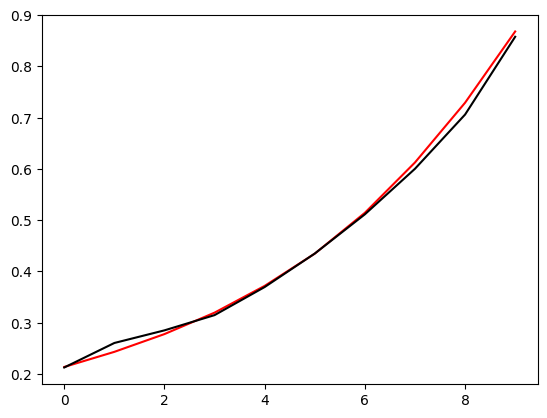

In [78]:
# Create figures
plt.plot(is_pulled_df['decile'], is_pulled_df['is_pulled_pred'], color='red')
plt.plot(is_pulled_df['decile'], is_pulled_df['pulled'], color='black')
plt.show() 

In [74]:
is_pulled_df[['pulled', 'is_pulled_pred']].mean()

pulled            0.455280
is_pulled_pred    0.458483
dtype: float64

In [20]:
is_pulled_df.head()

,decile,pulled,is_pulled_pred
0,0,0.000427,0.000105
1,1,0.000641,0.000229
2,2,0.000470,0.000405
3,3,0.000897,0.000691
4,4,0.001537,0.001187


In [18]:
X_train.query('pulled == 1').query('year_2022 == 1 or year_2023 == 1')[['faced_sum', 'IP_start', 'inning_adj', 'outs_adj', 'OUT']].describe()

,faced_sum,IP_start,inning_adj,outs_adj,OUT
count,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000
mean,22.800125,5.643576,6.214434,0.519759,16.163062
std,3.982093,0.278788,1.394804,0.783133,3.982752
min,1.000000,4.508454,1.000000,0.000000,0.000000
25%,21.000000,5.447654,5.000000,0.000000,14.000000
50%,23.000000,5.630972,6.000000,0.000000,17.000000
75%,25.000000,5.820993,7.000000,1.000000,18.000000
max,35.000000,6.595968,10.000000,2.000000,27.000000


In [19]:
X_test['inning'] = pd.to_numeric(X_test['inning'])
X_test['year'] = X_test['year'].astype('int')
X_test.query('pulled == 1').query('year_2022 == 1 or year_2023 == 1')[['is_pulled_pred', 'IP_start', 'faced_sum', 'inning_adj', 'outs_adj', 'OUT']].describe()

,is_pulled_pred,IP_start,faced_sum,inning_adj,outs_adj,OUT
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,0.391556,5.646005,22.665383,6.188703,0.498074,16.064185
std,0.272177,0.274271,4.082640,1.420222,0.774221,4.031998
min,0.000093,4.803679,2.000000,1.000000,0.000000,0.000000
25%,0.141895,5.453509,21.000000,5.000000,0.000000,14.000000
50%,0.359847,5.633421,23.000000,6.000000,0.000000,17.000000
75%,0.624938,5.819220,25.000000,7.000000,1.000000,18.000000
max,0.977099,6.613696,35.000000,10.000000,2.000000,27.000000
